# Trading Iron Butterflies Before Earnings on S&P 500 Equities

### Edward Yudolevich

Note: this notebook represents my thought/research process when initially discovering and working on this idea and is intentionally not optimized for runtime and code readability/aesthetics.


In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from run_ import run_parallel
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

## Identifying A Pattern: Changes In The Curvature Of Volatility Smile

This trade idea originated when I started testing for patterns in changes in the volatility surface of large market-cap US equities around the time of each company's earnings calls. I arbitrarily chose to compare the volatility surfaces from a week before earnings to market close before earnings, and from market close before earnings to a week after earnings, and as you will see in the rest of the project, this worked and I stuck with it. Similarly, I (again arbitrarily) chose to measure the steepness/curvature of the volatility smile as my first attempt at finding a pattern (as opposed to skew or something else) and this worked as well, and I stuck with it, too.

In the section below, I use two different methods of calculation of the curvature of the volatility surface:
Discrete = AVG(90% moneyness put IV, 110% monyness call IV) / AVG(100% moneyness put IV, 100% moneyness call IV)
Continuous = The 'a' term from (ax^2 + bx + c) when fitting a quadratic regression to the volatility surface, where the X (independent variable) is the logarithm of the % moneyness, effectively normalized strike price, and Y (dependent variable) is the IV.

I compare changes using both of these measures in the week leading up to earnings, and in the week after earnings, as described above.

In [2]:
df_curve_changes = run_parallel(['curve_changes', 'curve_changes'], kwargs={'func_kwargs': [{'method': 'continuous'}, {'method': 'discrete'}]})
def transform_ser(dict_series: pd.Series, before: bool) -> pd.Series:
    kwd: str = 'before' if before else 'after'
    series = dict_series.apply(lambda change_dict: change_dict.get(kwd) if not pd.isna(change_dict) else np.nan)
    return series

df_curve_changes['discrete before'] = transform_ser(df_curve_changes['curve_changes, method=discrete'], True)
df_curve_changes['discrete after'] = transform_ser(df_curve_changes['curve_changes, method=discrete'], False)
df_curve_changes['continuous before'] = transform_ser(df_curve_changes['curve_changes, method=continuous'], True)
df_curve_changes['continuous after'] = transform_ser(df_curve_changes['curve_changes, method=continuous'], False)

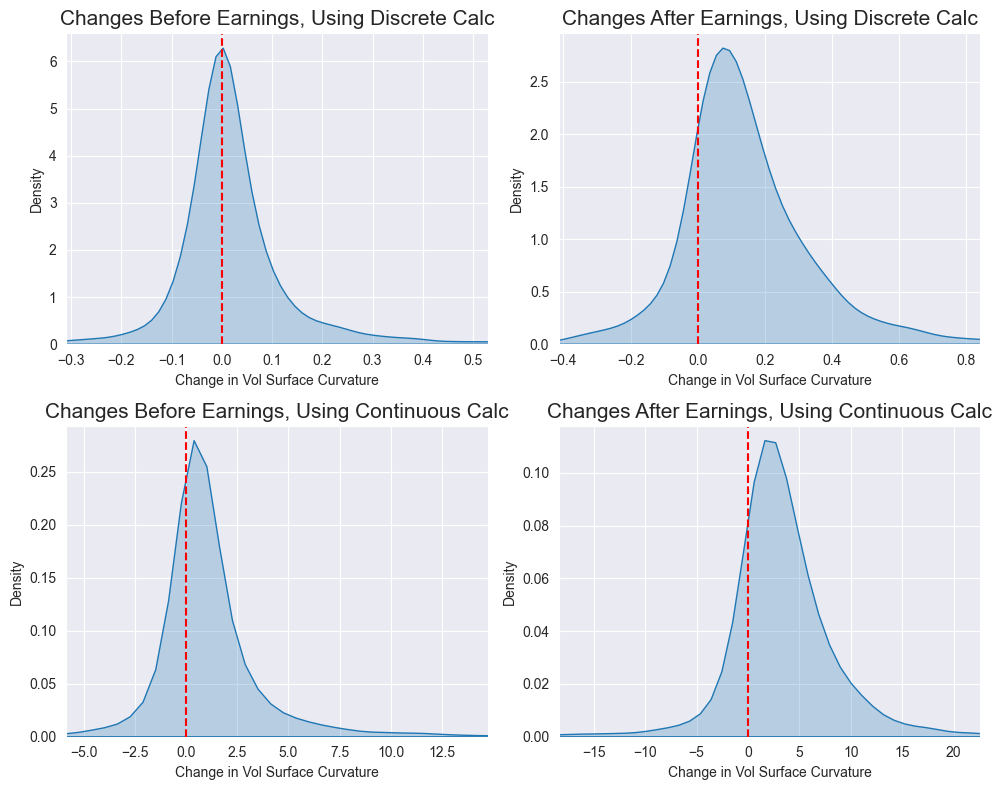

In [3]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
def curve_changes_kdeplot(series_name: str, ax: plt.axis) -> None:
    words = series_name.split(" ")
    method = words[0]
    when = words[1]
    sns.kdeplot(df_curve_changes[series_name], fill=True, ax=ax)
    ax.set_xlim([df_curve_changes[series_name].quantile(0.01), df_curve_changes[series_name].quantile(0.99)])
    ax.axvline(0, color='red', linestyle='dashed', label=0)
    ax.set_xlabel('Change in Vol Surface Curvature', fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.set_title(f'Changes {when.title()} Earnings, Using {method.title()} Calc', fontsize=15)

curve_changes_kdeplot('discrete before', ax=ax1)
curve_changes_kdeplot('discrete after', ax=ax2)
curve_changes_kdeplot('continuous before', ax=ax3)
curve_changes_kdeplot('continuous after', ax=ax4)
plt.tight_layout()
plt.show()

In [4]:
t_stat_discrete = stats.ttest_1samp(a=df_curve_changes['discrete after'].astype('float64').dropna(), popmean = 0)[0]
t_stat_continuous = stats.ttest_1samp(a=df_curve_changes['continuous after'].astype('float64').dropna(), popmean = 0)[0]
print(f"The T-Stat for whether the 'Changes After Earnings Using Discrete Calc' distribution is significantly different from 0 is {t_stat_discrete:.4}")
print(f"The T-Stat for whether the 'Changes After Earnings Using Continuous Calc' distribution is significantly different from 0 is {t_stat_continuous:.4}")

The T-Stat for whether the 'Changes After Earnings Using Discrete Calc' distribution is significantly different from 0 is 39.13
The T-Stat for whether the 'Changes After Earnings Using Continuous Calc' distribution is significantly different from 0 is 26.71


We can see that when measuring changes in the week after earnings, both the discrete and continuous calculation methods yield results that are very statistically significant, and we can see this from the density plots even more clearly. Intuitively, this means that the volatility surface for a given options chain tends to become MORE steep/curved in the week after the earnings call.

Although this is interesting, it doesn't actually yield any ideas for a trade on its own, since we are not holding strikes constant: in other words, it is possible that due to delta moves in the underlying, the true behavior of the option chain is masked and does not match what we see in this analysis.

## Does This Pattern Hold With Fixed Strikes -- Can We Translate It Into A Trade?

In this section, I change the approach slightly to keep strikes constant. I am no longer using the continuous calculation method but rather sticking with the 90-100-110%
moneyness butterfly idea, since this easily translates to a possible trade structure. Here, I also take vega into account: ATM vega tends to be higher than OTM vega, and consequently, simply saying that OTM vol tends to increase relative to ATM vol does not indicate that being long OTM vol and short ATM vol will translate into a profitable edge. So, in this section I scale the IV changes according to the average value of the option's vega during the week after earnings, and then take the difference between the OTM change vs the ATM change.

Intuitively, a positive value for this result indicates (very roughly, because there are many other factors at play) that purely in terms of volatility changes, holding an iron butterfly position would have yielded positive vega PnL.

In [5]:
df_vol_changes = run_parallel('vol_changes')

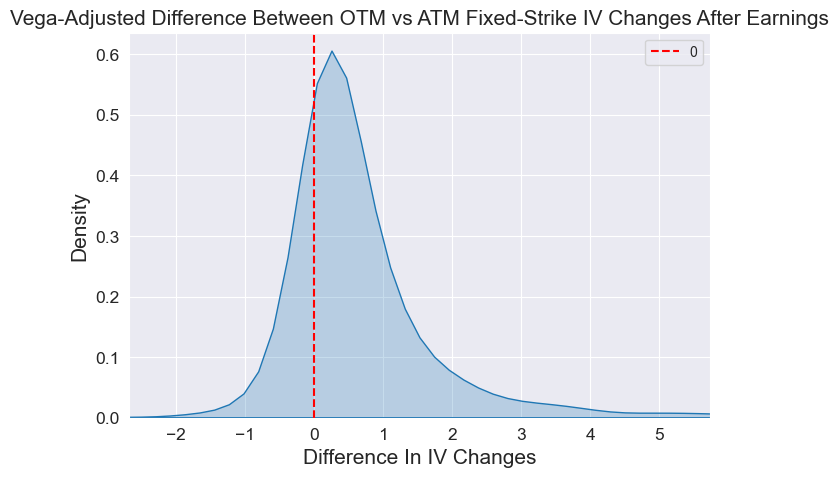

The T-Stat for whether this distribution is significantly different from 0 is 26.3


In [20]:
plt.figure(figsize = (7.5, 5))
ax = sns.kdeplot(df_vol_changes['vol_changes'], fill=True)
plt.xlim([df_vol_changes['vol_changes'].quantile(0.001), df_vol_changes['vol_changes'].quantile(0.98)])
ax.axvline(0, color = 'red', linestyle = 'dashed', label = 0)
plt.xlabel('Difference In IV Changes', fontsize = 15)
plt.ylabel('Density', fontsize = 15)
plt.title('Vega-Adjusted Difference Between OTM vs ATM Fixed-Strike IV Changes After Earnings', fontsize = 15)
plt.xticks(fontsize = 12.5)
plt.yticks(fontsize = 12.5)
plt.legend()
plt.show()
t_stat = stats.ttest_1samp(a=df_vol_changes['vol_changes'].astype('float64').dropna(), popmean = 0)[0]
print(f"The T-Stat for whether this distribution is significantly different from 0 is {t_stat:.4}")

Thankfully, we can see that the pattern from the previous section holds, and that on average, trading iron butterflies seems to produce positive vega PnL. Hopefully, if other factors in the trading PnL will average out over time, we can harness this edge by continuously entering the iron butterflies right before earnings and holding for a week.

## Running Initial Backtest

As described above, this section runs the backtest of a strategy that systematically enters a long iron butterfly position on the top 250 S&P 500 companies suing the 90-100-110% moneyness strike placement and holds for a week. The expiry is chosen to always be as close to 2 weeks from the day of the earnings date. Transaction costs are accounted for by assuming that we can buy halfway between the mid-price and the ask price, and can sell halfway between the bid price and the mid-price (in other words, we always cross half the spread on each leg of the trade).

In [7]:
df_orig = run_parallel(['pnl', 'avg_exit_size_ratio', 'quality_of_fill'])

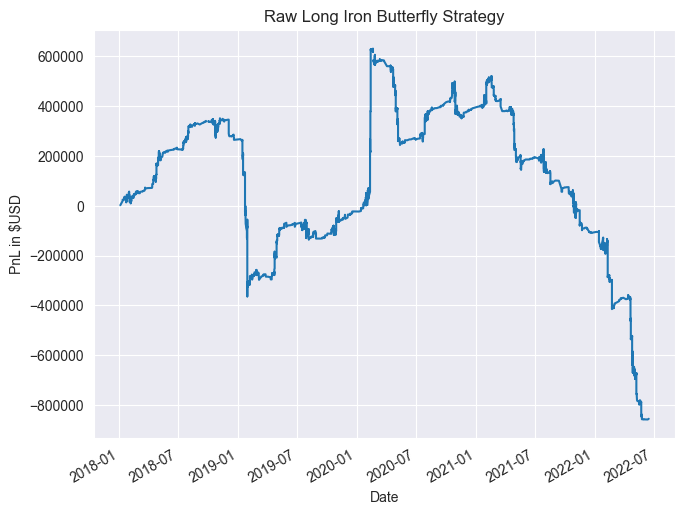

In [28]:
df_orig['Portfolio History'] = df_orig['pnl'].cumsum()
df_orig['Portfolio History'].plot(
    title='Raw Long Iron Butterfly Strategy',
    xlabel='Date', ylabel='PnL in $USD', figsize=(7.5, 6)
)
plt.show()

On its own, this systematic strategy doesn't work very well. This makes sense intuitively: although we have an edge in the long run on the vega PnL, constantly crossing half the spread on each leg, entering even when prices are not favorable in the market, and entering in size that is not reliably offloaded at the time of exit, are all factors that contribute to the failure of this strategy. While we can't do anything about the transaction costs, we can try to mitigate the effect of decreased volume at the time of exit vs at the time of entry by only entering a portion of the available size in the market, and try to ensure that we only enter these butterflies when market prices are actually favorable for such a position. In the correlation matrix below, 'avg_exit_size_ratio' represents the average ratio (between all the legs of the trade) of (exit size) / (entry size), and 'quality_of_fill' represents the value (net credit received on entry for the butterfly position) / (the price of the underlying at the time of entry).

In [10]:
df_orig[['pnl', 'avg_exit_size_ratio', 'quality_of_fill']].corr().style.background_gradient(cmap='viridis')

,pnl,avg_exit_size_ratio,quality_of_fill
pnl,1.000000,0.095191,0.078319
avg_exit_size_ratio,0.095191,1.000000,0.315714
quality_of_fill,0.078319,0.315714,1.000000


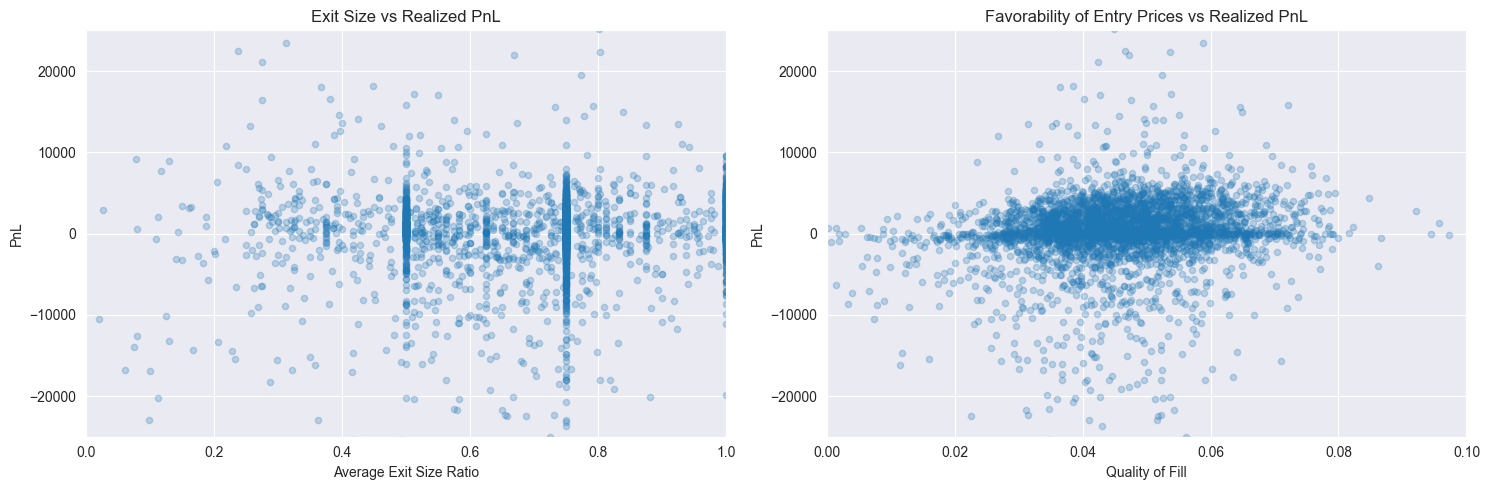

In [22]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
df_orig.plot(
    kind='scatter', x='avg_exit_size_ratio', y='pnl', alpha=0.25, ylim=[-25000, 25000],
    xlim=[0, 1], grid=True, title='Exit Size vs Realized PnL',
    xlabel='Average Exit Size Ratio', ylabel='PnL', ax=ax1
)
df_orig.plot(
    kind='scatter', x='quality_of_fill', y='pnl', alpha=0.25, ylim=[-25000, 25000],
    xlim=[0, 0.1], grid=True, title='Favorability of Entry Prices vs Realized PnL',
    xlabel='Quality of Fill', ylabel='PnL', ax=ax2
)
plt.tight_layout()
plt.show()

We can see that both the exit size and quality of fill impact the realized PnL on average, so it makes sense to try to filter for both of these. The relationships are not extremely strong in either case, but we can see general trends from the scatterplots and certainly notice that significant losers tend to occur with lower exit sizes and lower quality of fill, and vice versa.

## Filtering Results, Arriving At Final Strategy

Below, I re-run the raw backtest above but only enter into half of the available size in the market (chosen without any optimization, just from visual examination of the scatterplot above), and then filter by quality of fill (threshold was chosen again without any manual optimization) to remove trades that were unfavorable at the time of entry.

In [13]:
df_adj = run_parallel(
    ['pnl', 'avg_exit_size_ratio', 'quality_of_fill'],
    kwargs={'func_kwargs': [{'entry_size_ratio': 0.5}, {}, {}]}
)
df_adj.rename(columns={'pnl, entry_size_ratio=0.5': 'pnl'}, inplace=True)

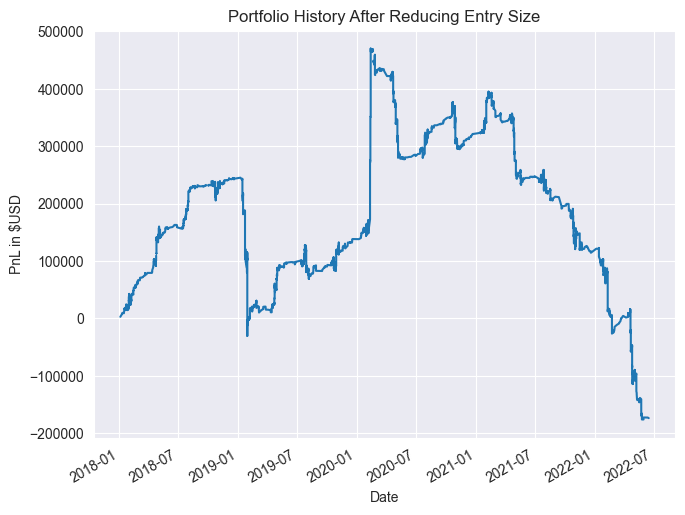

In [26]:
df_adj['Portfolio History'] = df_adj['pnl'].cumsum()
df_adj['Portfolio History'].plot(
    title='Portfolio History After Reducing Entry Size',
    xlabel='Date', ylabel='PnL in $USD', figsize=(7.5, 6)
)
plt.show()

There is already a good deal of improvement here from the raw strategy but the overall structure of the PnL curve is very similar. Let's see if filtering by quality of fill helps more. Based on the scatterplot above, I selected to use 0.05 as a threshold for entry.

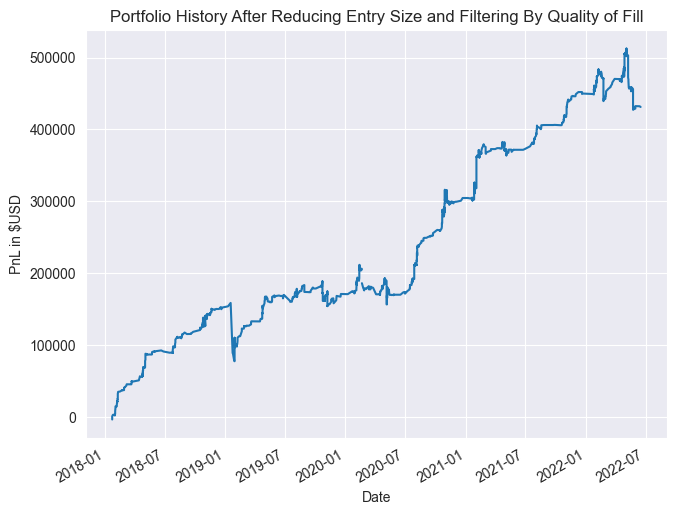

In [27]:
df_final = df_adj[df_adj['quality_of_fill'] > 0.05].copy()
df_final['Portfolio History'] = df_final['pnl'].cumsum()
df_final['Portfolio History'].plot(
    title='Portfolio History After Reducing Entry Size and Filtering By Quality of Fill',
    xlabel='Date', ylabel='PnL in $USD', figsize=(7.5, 6)
)
plt.show()

Finally, we have a decent trading strategy. It is certainly not foolproof and does have some pretty significant drawdowns as well as very significant capacity constraints (this strategy is not scalable and the $PnL on the y-axis on the plot is actually reflective of the capacity of the strategy), but the long-term performance is quite strong. To quickly sum up, the final strategy is as follows:

1. Find an S&P 500 company's earnings call date.
2. At the market close before this date, find the option chain that is closest to but at least 2 weeks away from expiry.
3. Identify the iron butterfly that would be formed from this option chain with the 90% put, 100% put, 100% call, and 110% call.
4. If the net credit that would be received from entering this position is greater than 5% of the underlying price, enter the trade in half of the total available size in the market.
5. Exit the trade exactly a week after entry. If there is no available size to fully offload the position, keep trying to exit as the days go by, otherwise holding to expiry is not extremely unprofitable.

The final Sharpe ratio for this filtered strategy is shown below.

In [17]:
trades_per_year = len(df_final) / 4.5  # we have more than one trade per day on average so scale by the average # of trading days
sharpe = (df_final['pnl'].mean() / df_final['pnl'].std()) * np.sqrt(trades_per_year)
print(f"The Sharpe Ratio of the strategy is {sharpe:.4}")

The Sharpe Ratio of the strategy is 1.504
